## Going deeper with Autoencoders

In [1]:
import torch
import torch.nn as nn
import numpy as np
from torchvision.datasets import MNIST
from torchvision import transforms
from torchinfo import summary
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

import utils
from autoencoder import AutoEncoder

In [2]:
# define transforms and get the MNIST data
tfms = transforms.Compose([transforms.ToTensor()])
data = MNIST("/home/lakshya/work/data", transform=tfms, download=False)
train_data, valid_data = torch.utils.data.random_split(data, [50000, 10000])

# dataloader
trainloader = torch.utils.data.DataLoader(
    train_data, batch_size=32, shuffle=False, num_workers=8, pin_memory=True
)
validloader = torch.utils.data.DataLoader(
    valid_data, batch_size=32, shuffle=False, num_workers=8, pin_memory=True
)

In [3]:
# create the model and display its summary
model = AutoEncoder()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
summary(model, input_size=(32, 1, 28, 28), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoder                              [32, 2]                   --
├─Sequential: 1-1                        [32, 2]                   --
│    └─Conv2d: 2-1                       [32, 16, 28, 28]          160
│    └─LeakyReLU: 2-2                    [32, 16, 28, 28]          --
│    └─MaxPool2d: 2-3                    [32, 16, 14, 14]          --
│    └─BatchNorm2d: 2-4                  [32, 16, 14, 14]          32
│    └─Conv2d: 2-5                       [32, 32, 7, 7]            4,640
│    └─LeakyReLU: 2-6                    [32, 32, 7, 7]            --
│    └─MaxPool2d: 2-7                    [32, 32, 3, 3]            --
│    └─BatchNorm2d: 2-8                  [32, 32, 3, 3]            64
│    └─Conv2d: 2-9                       [32, 32, 2, 2]            9,248
│    └─LeakyReLU: 2-10                   [32, 32, 2, 2]            --
│    └─MaxPool2d: 2-11                   [32, 32, 1, 1]            --
│    └─B

In [4]:
# loss function, optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-5)

In [5]:
# example samples for visualization
samples = next(iter(validloader))

In [6]:
# start training
sample_outputs = utils.train(
    trainloader,
    epochs=100,
    model=model,
    device=device,
    criterion=criterion,
    optimizer=optimizer,
    samples=samples,
    print_every=10,
)

Epoch: [10/100], Loss: 0.2243
Epoch: [20/100], Loss: 0.2238
Epoch: [30/100], Loss: 0.2234
Epoch: [40/100], Loss: 0.2231
Epoch: [50/100], Loss: 0.2228
Epoch: [60/100], Loss: 0.2227
Epoch: [70/100], Loss: 0.2226
Epoch: [80/100], Loss: 0.2225
Epoch: [90/100], Loss: 0.2224
Epoch: [100/100], Loss: 0.2223


In [7]:
# select random images from the dataset to display
indices = np.random.choice(range(32), 10, replace=False)

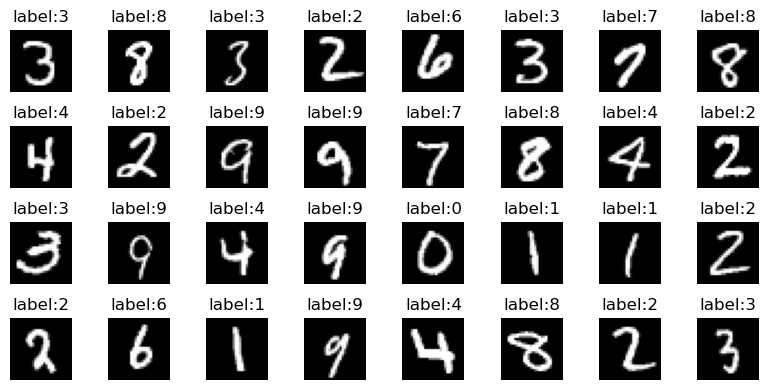

In [8]:
# plot sample images
utils.plot_images(samples)

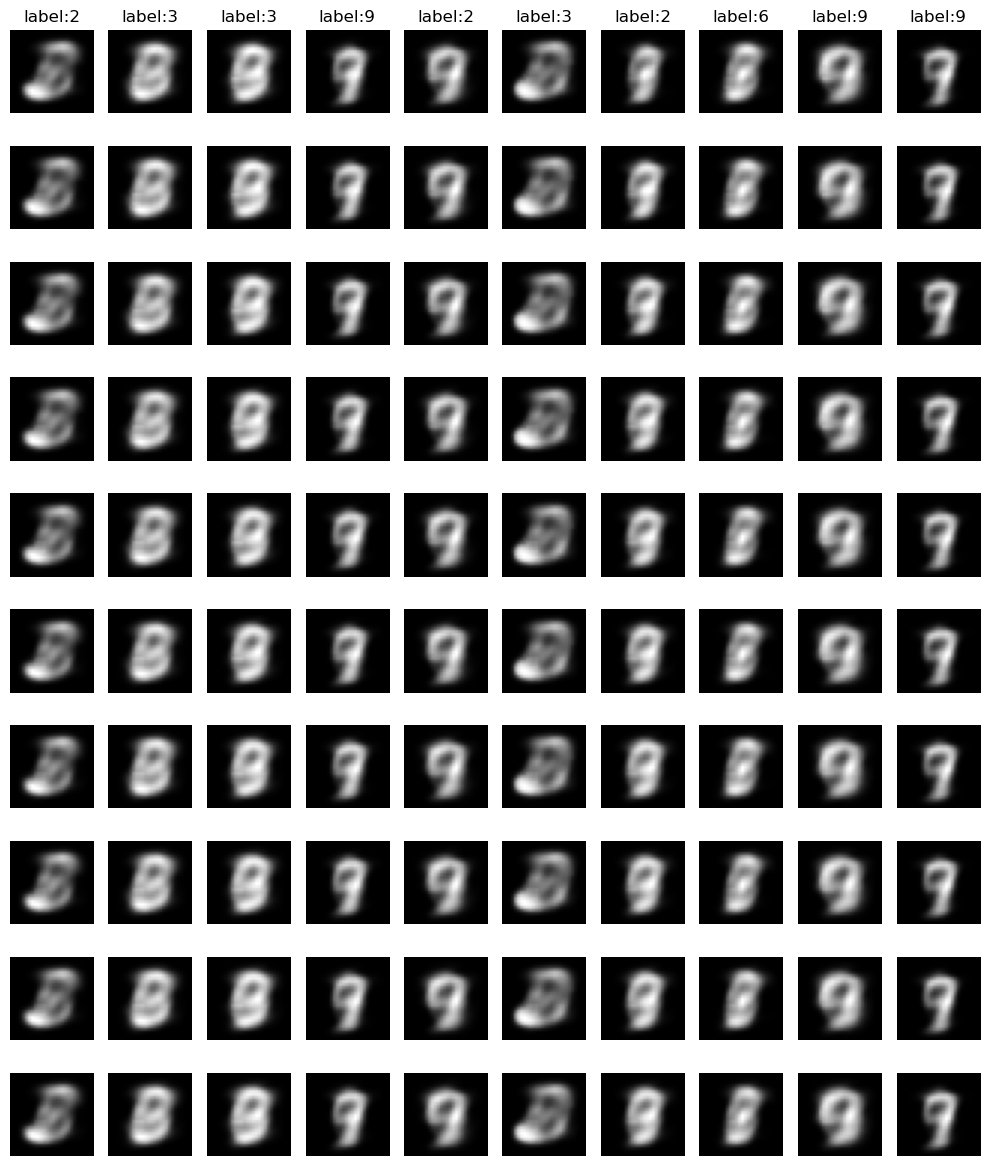

In [9]:
# plot outputs every 5 epochs
utils.plot_outputs(sample_outputs, samples[1], indices)

## Visualizing the latent space

In [10]:
example_ds = torch.utils.data.Subset(valid_data, range(5000))
latent_space = []
labels = []
for i in range(len(example_ds)):
    image, label = example_ds[i]
    model.eval()
    model = model.to("cpu")
    image = image[None, :, :, :]
    encoder_out, _ = model(image)
    encoder_out = encoder_out.detach().cpu().numpy().squeeze()
    latent_space.append(encoder_out)
    labels.append(label)

In [11]:
latent_space = np.array(latent_space)

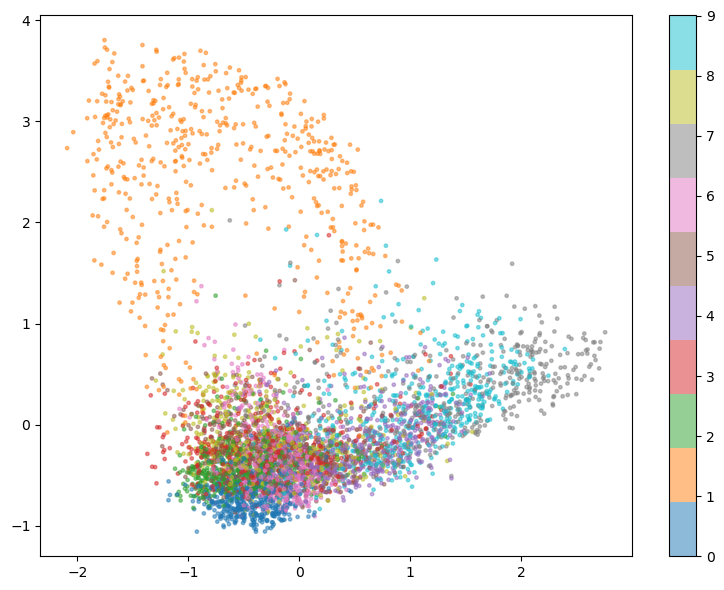

In [12]:
plt.figure(figsize=(8, 6), dpi=100)
plt.scatter(
    latent_space[:, 0],
    latent_space[:, 1],
    cmap="tab10",
    c=labels,
    alpha=0.5,
    s=6,
)
plt.colorbar()
plt.tight_layout()
plt.show()

## Generating new images

In [13]:
mins, maxs = np.min(latent_space, axis=0), np.max(latent_space, axis=0)
recon_examples = np.random.uniform(mins, maxs, size=(18, 2))
recon_examples_tensor = torch.tensor(recon_examples, dtype=torch.float32)
reconstructions = model.decoder(recon_examples_tensor).detach().cpu().numpy()

In [14]:
reconstructions.shape

(18, 1, 28, 28)

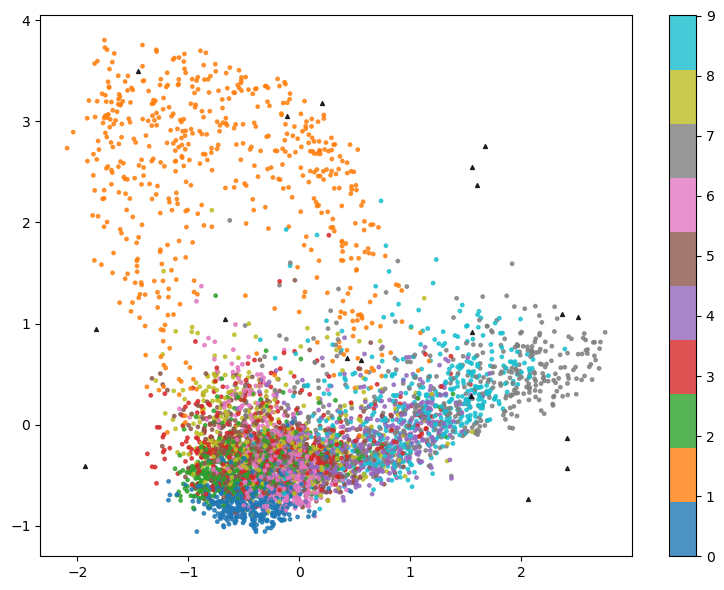

In [15]:
plt.figure(figsize=(8, 6), dpi=100)
plt.scatter(
    latent_space[:, 0],
    latent_space[:, 1],
    cmap="tab10",
    c=labels,
    alpha=0.8,
    s=6,
)
plt.colorbar()
plt.scatter(
    recon_examples[:, 0],
    recon_examples[:, 1],
    c="k",
    marker="^",
    alpha=0.8,
    s=8,
)
plt.tight_layout()
plt.show()

In [16]:
latent_space.shape

(5000, 2)

In [17]:
grid_size = 20
x = np.linspace(min(latent_space[:, 0]), max(latent_space[:, 0]), grid_size)
y = np.linspace(min(latent_space[:, 1]), max(latent_space[:, 1]), grid_size)

xv, yv = np.meshgrid(x, y)
z = np.array(list(zip(xv.flatten(), yv.flatten())))

z_tensor = torch.tensor(z, dtype=torch.float32)
reconstructions = model.decoder(z_tensor).detach().cpu().numpy().squeeze()

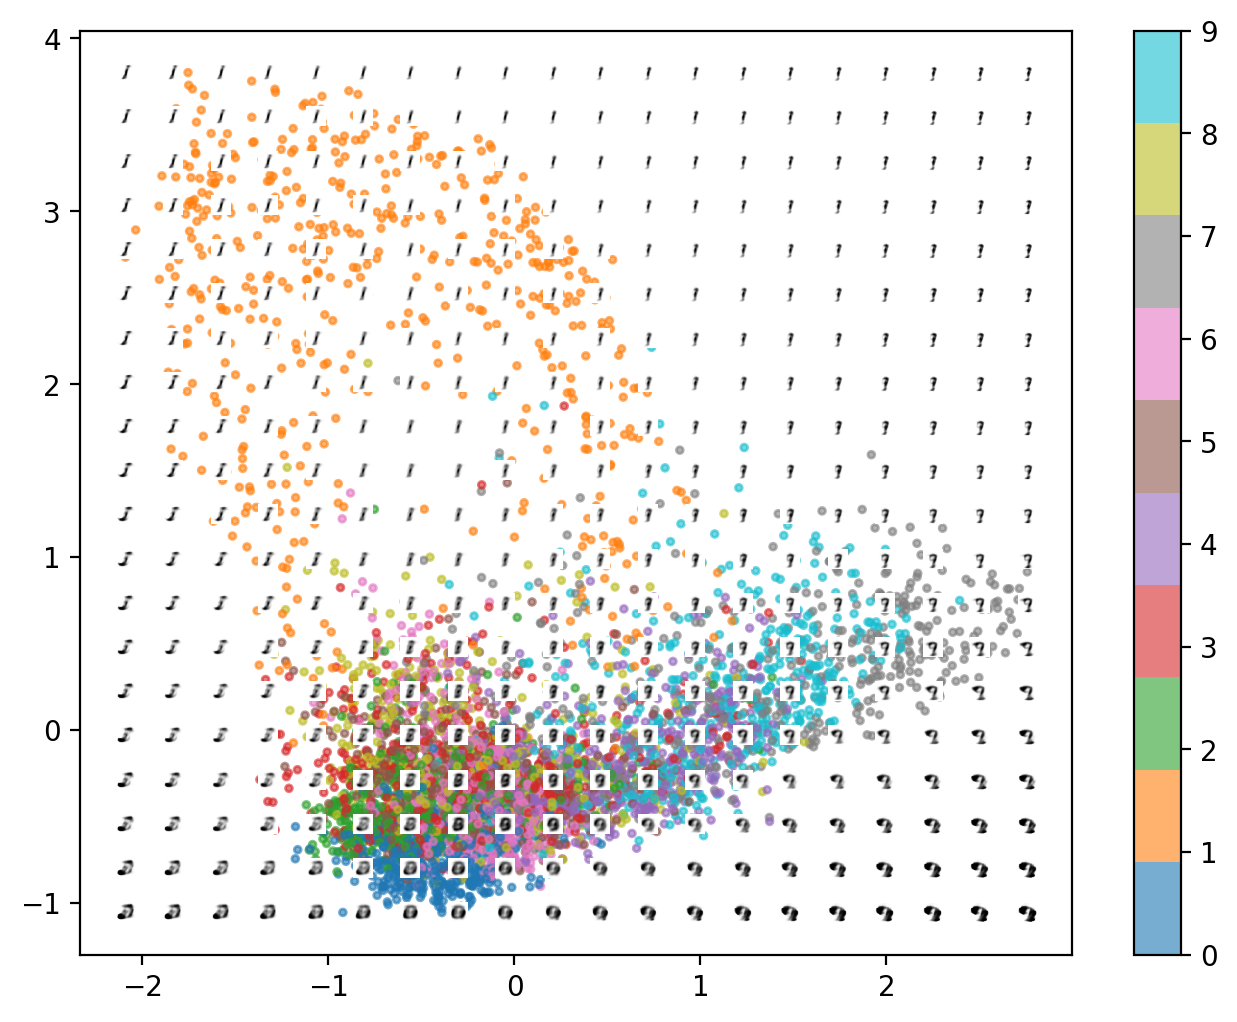

In [19]:
fig = plt.figure(figsize=(8, 6), dpi=200)
ax = fig.add_subplot()
for img, coord in zip(reconstructions, z):
    img_box = AnnotationBbox(
        OffsetImage(img, zoom=0.25, cmap="gray_r"),
        coord,
        alpha=0.1,
        frameon=False,
    )
    ax.add_artist(img_box)
    ax.set_axis_off()
ax = plt.gcf().gca()
ret = ax.scatter(
    latent_space[:, 0],
    latent_space[:, 1],
    cmap="tab10",
    c=labels,
    alpha=0.6,
    s=6,
)
ax.set_axis_on()
plt.colorbar(ret)
plt.show()